In [51]:
import yfinance as yf 
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout 
from keras.optimizers import Adam
from math import sqrt
from keras.utils import plot_model
import pmdarima as pm

Resources and Documentation utilized for Model Development-
1. yfinance (Yahoo Finance)
Documentation: https://pypi.org/project/yfinance/
2. pandas (Python Data Analysis Library)
Documentation: https://pandas.pydata.org/pandas-docs/stable/index.html
3. datetime (Datetime module in Python standard library)
Documentation: https://docs.python.org/3/library/datetime.html
4. numpy (Numerical Python)
Documentation: https://numpy.org/doc/stable/ 
5. matplotlib (Python plotting library)
Documentation: https://matplotlib.org/stable/contents.html 
6. seaborn (Statistical Data Visualization)
Documentation: https://seaborn.pydata.org/ 
7. scikit-learn (Machine Learning in Python)
Documentation: https://scikit-learn.org/stable/index.html 
8. Keras (Deep Learning for humans)
Documentation: https://keras.io/ 
9. pmdarima (Arima modeling in Python)
Documentation: http://alkaline-ml.com/pmdarima/ 


Fetching the Historical Stock Data

In [52]:
tickers = ["AMZN", "META", "GOOGL"]
 
start_date = dt.datetime.now() - dt.timedelta(days = 6*365)
end_date = dt.datetime.now()
 
stock_data = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    stock_data[ticker] = stock.history(start = start_date, end = end_date).dropna()
 
data = pd.concat(stock_data.values(), axis =1, keys= stock_data.keys())

data.index = pd.to_datetime(data.index)
print(data.head())
data.describe()

                                AMZN                                   \
                                Open       High        Low      Close   
Date                                                                    
2017-04-19 00:00:00-04:00  45.391998  45.525002  44.868500  44.959999   
2017-04-20 00:00:00-04:00  44.985001  45.265999  44.814499  45.103001   
2017-04-21 00:00:00-04:00  45.133499  45.182499  44.838501  44.926498   
2017-04-24 00:00:00-04:00  45.433998  45.499500  45.191002  45.370499   
2017-04-25 00:00:00-04:00  45.352001  45.473999  45.150002  45.381001   

                                                                  META  \
                             Volume Dividends Stock Splits        Open   
Date                                                                     
2017-04-19 00:00:00-04:00  57404000       0.0          0.0  141.350006   
2017-04-20 00:00:00-04:00  56288000       0.0          0.0  142.949997   
2017-04-21 00:00:00-04:00  48410000       0.0

AMZN                                                       \
              Open         High          Low        Close        Volume   
count  1509.000000  1509.000000  1509.000000  1509.000000  1.509000e+03   
mean    110.676078   111.989797   109.212172   110.617983  8.377297e+07   
std      39.544954    40.029862    39.009504    39.483841  3.994921e+07   
min      44.985001    45.182499    44.814499    44.926498  1.762600e+07   
25%      84.210999    85.275002    83.204002    84.456001  5.732800e+07   
50%      96.989998    97.949997    95.699997    97.152496  7.204200e+07   
75%     154.913498   156.644501   151.856995   154.474503  9.858200e+07   
max     187.199997   188.654007   184.839493   186.570496  3.313000e+08   

                                     META                            ...  \
      Dividends Stock Splits         Open         High          Low  ...   
count    1509.0  1509.000000  1509.000000  1509.000000  1509.000000  ...   
mean        0.0     0.013254   209.641855   212.469231   206.938363  ...   
std         0.0     0.514856    64.284228    64.932160    63.574706  ...   
min         0.0     0.000000    90.080002    90.459999    88.089996  ...   
25%         0.0     0.000000   167.160004   169.300003   165.000000  ...   
50%         0.0     0.000000   187.039993   189.500000   184.850006  ...   
75%         0.0     0.000000   249.039993   252.800003   246.610001  ...   
max         0.0    20.000000   381.679993   384.329987   378.809998  ...   

                                                  GOOGL               \
             Volume Dividends Stock Splits         Open         High   
count  1.509000e+03    1509.0       1509.0  1509.000000  1509.000000   
mean   2.356045e+07       0.0          0.0    81.902682    82.808022   
std    1.632930e+07       0.0          0.0    30.714152    31.056299   
min    6.046300e+06       0.0          0.0    42.869499    43.009998   
25%    1.453790e+07       0.0          0.0    55.968498    56.666500   
50%    1.946500e+07       0.0          0.0    70.958504    71.747002   
75%    2.745080e+07       0.0          0.0   104.985497   106.300003   
max    2.323166e+08       0.0          0.0   151.250000   151.546494   

                                                                      
               Low        Close        Volume Dividends Stock Splits  
count  1509.000000  1509.000000  1.509000e+03    1509.0  1509.000000  
mean     81.011939    81.934842  3.516953e+07       0.0     0.013254  
std      30.333321    30.692323  1.588415e+07       0.0     0.514856  
min      42.676498    42.825500  9.312000e+06       0.0     0.000000  
25%      55.428001    55.997002  2.519400e+07       0.0     0.000000  
50%      69.797501    70.714996  3.112600e+07       0.0     0.000000  
75%     104.040001   105.027000  4.008000e+07       0.0     0.000000  
max     148.899002   149.838501  1.331780e+08       0.0    20.000000  

[8 rows x 21 columns]

In [53]:
total = data.size
print(f'Total values- {total}') 
null= data.isnull() 
total_null = null.sum().sum()
print(f'total number of null values : {total_null}') 
data.to_csv("combinedData.csv")

Total values- 31689
total number of null values : 0


We can see from the above output that the total number of null values in our dataset is zero, meaning we can now procees to the next step - analysis of our data and adding technical indicators for better analysis

Exploratory Data Analysis

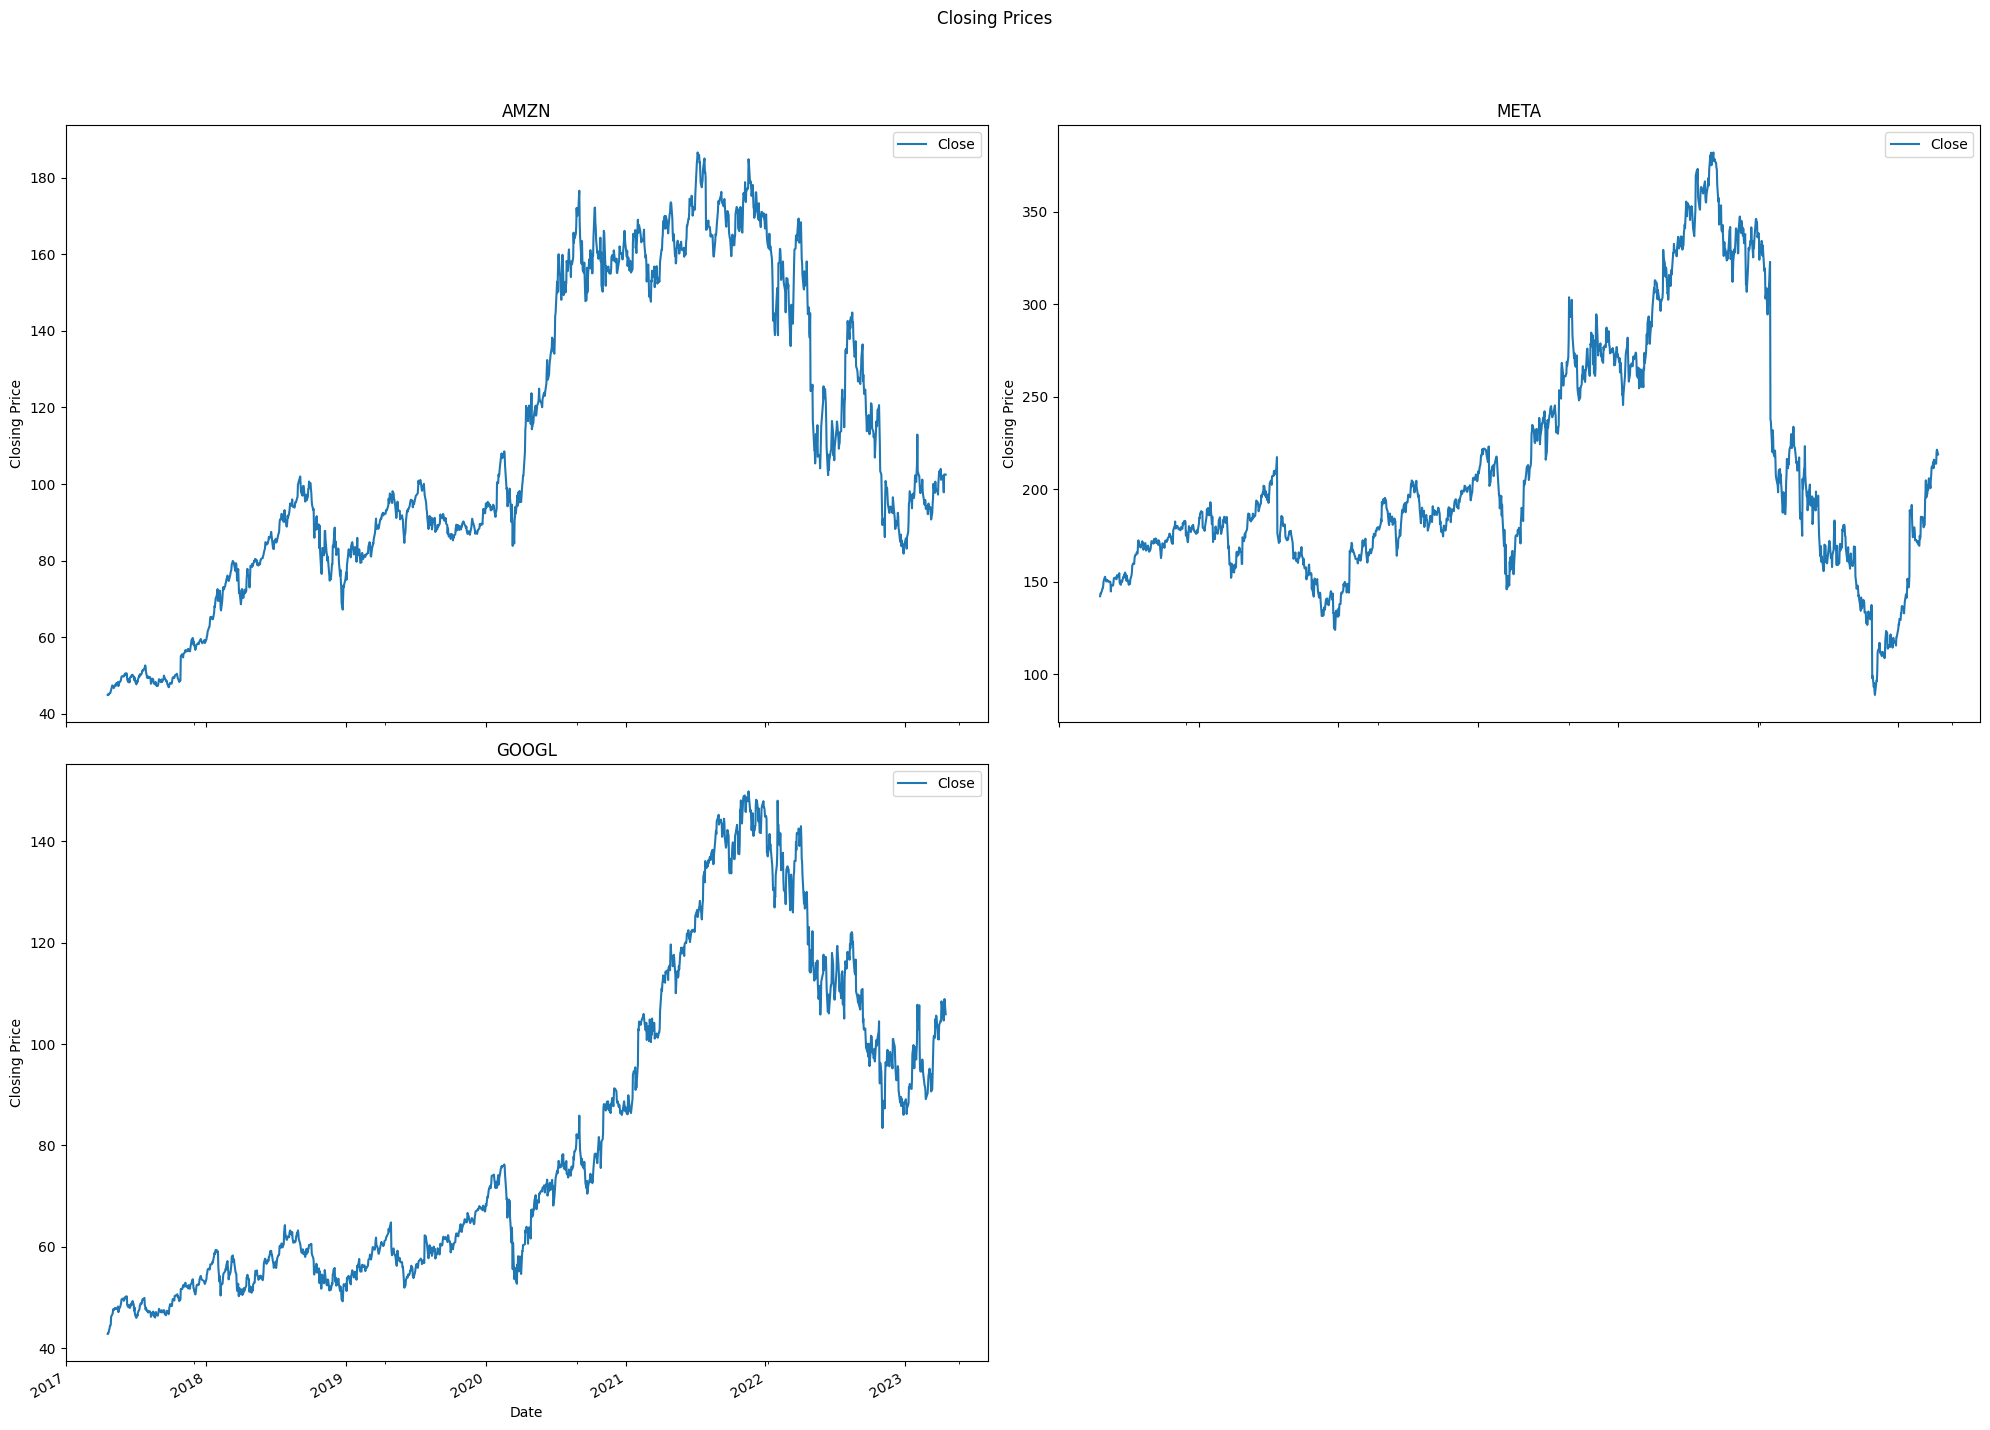

In [54]:
#Plotting the Closing Prices for Amazon, Meta, Google
AdjClose = data.loc[:,(slice(None), 'Close')]  
numrows = len(tickers) // 2 + len(tickers) % 2  
numcols = 2
fig, axs = plt.subplots(nrows= numrows, ncols = numcols, figsize = (20,15), sharex = True)
fig.suptitle('Closing Prices')

axs_flat = axs.flatten()  

for i, ticker in enumerate(tickers):
    AdjClose[ticker].plot(ax=axs_flat[i], title = ticker)
    axs_flat[i].set_xlabel('Date')
    axs_flat[i].set_ylabel('Closing Price') 

fig.delaxes(axs_flat[-1])

 
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

 

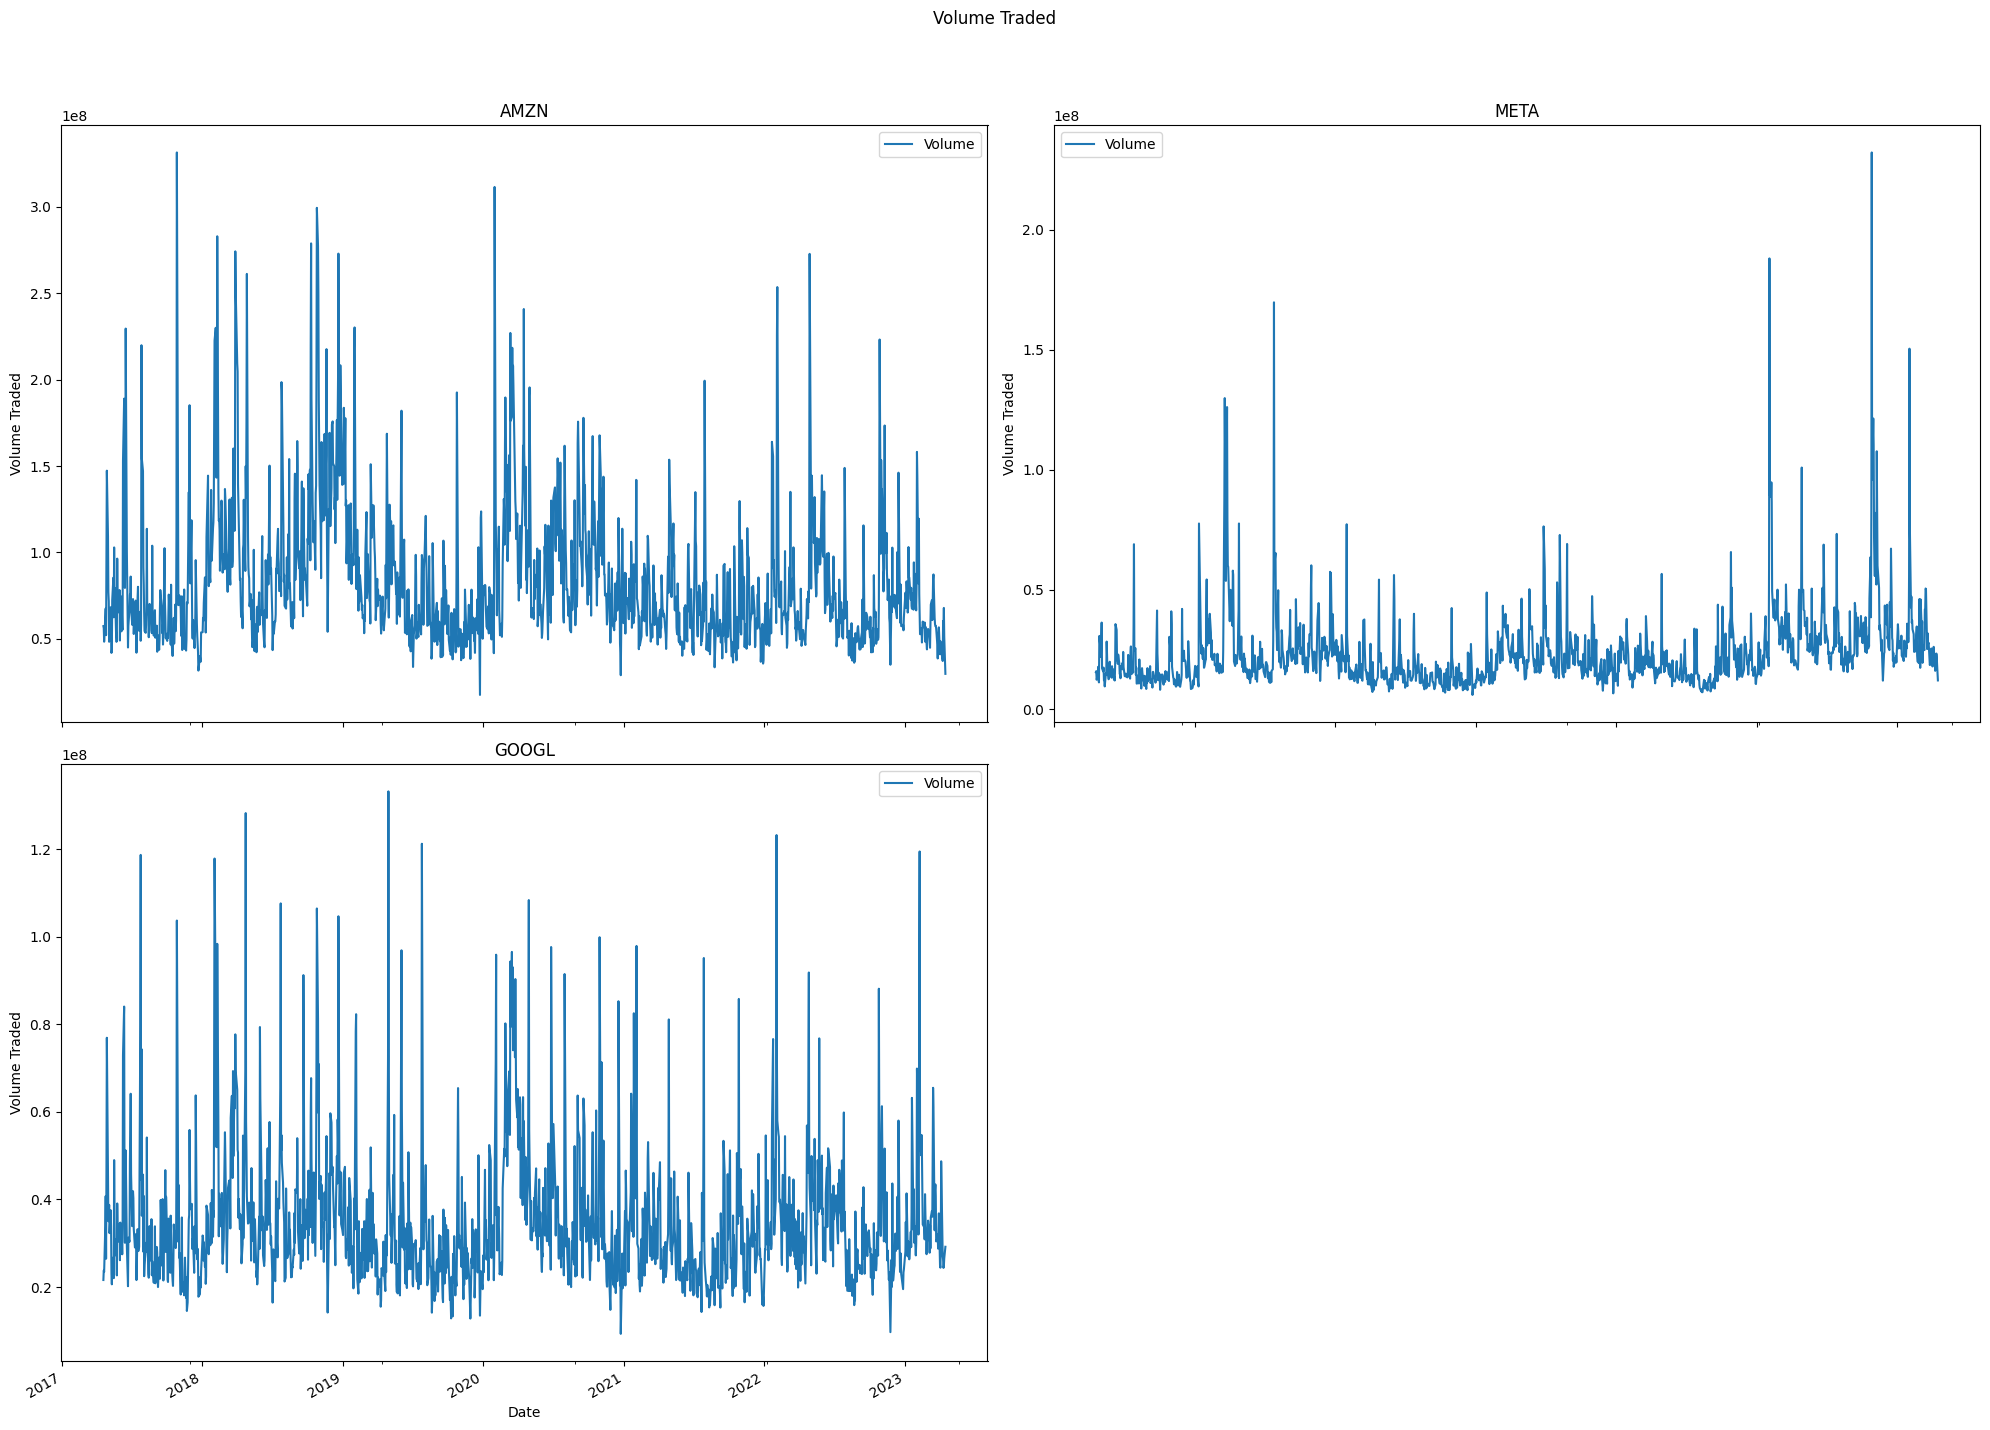

In [55]:
#Plotting the total Volume Traded for Amazon, Meta, Google
VolumeTraded = data.loc[:,(slice(None), 'Volume')]
numrows = len(tickers) // 2 + len(tickers) % 2 
numcols = 2

fig, axs = plt.subplots(nrows= numrows, ncols = numcols, figsize = (20,15), sharex = True)
fig.suptitle('Volume Traded')

axs_flat = axs.flatten()  

for i, ticker in enumerate(tickers):
    VolumeTraded[ticker].plot(ax=axs_flat[i], title = ticker)
    axs_flat[i].set_xlabel('Date')
    axs_flat[i].set_ylabel('Volume Traded') 
    
fig.delaxes(axs_flat[-1])
 
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Calculating Moving Average of the Adjusted Closing Prices for the companies 

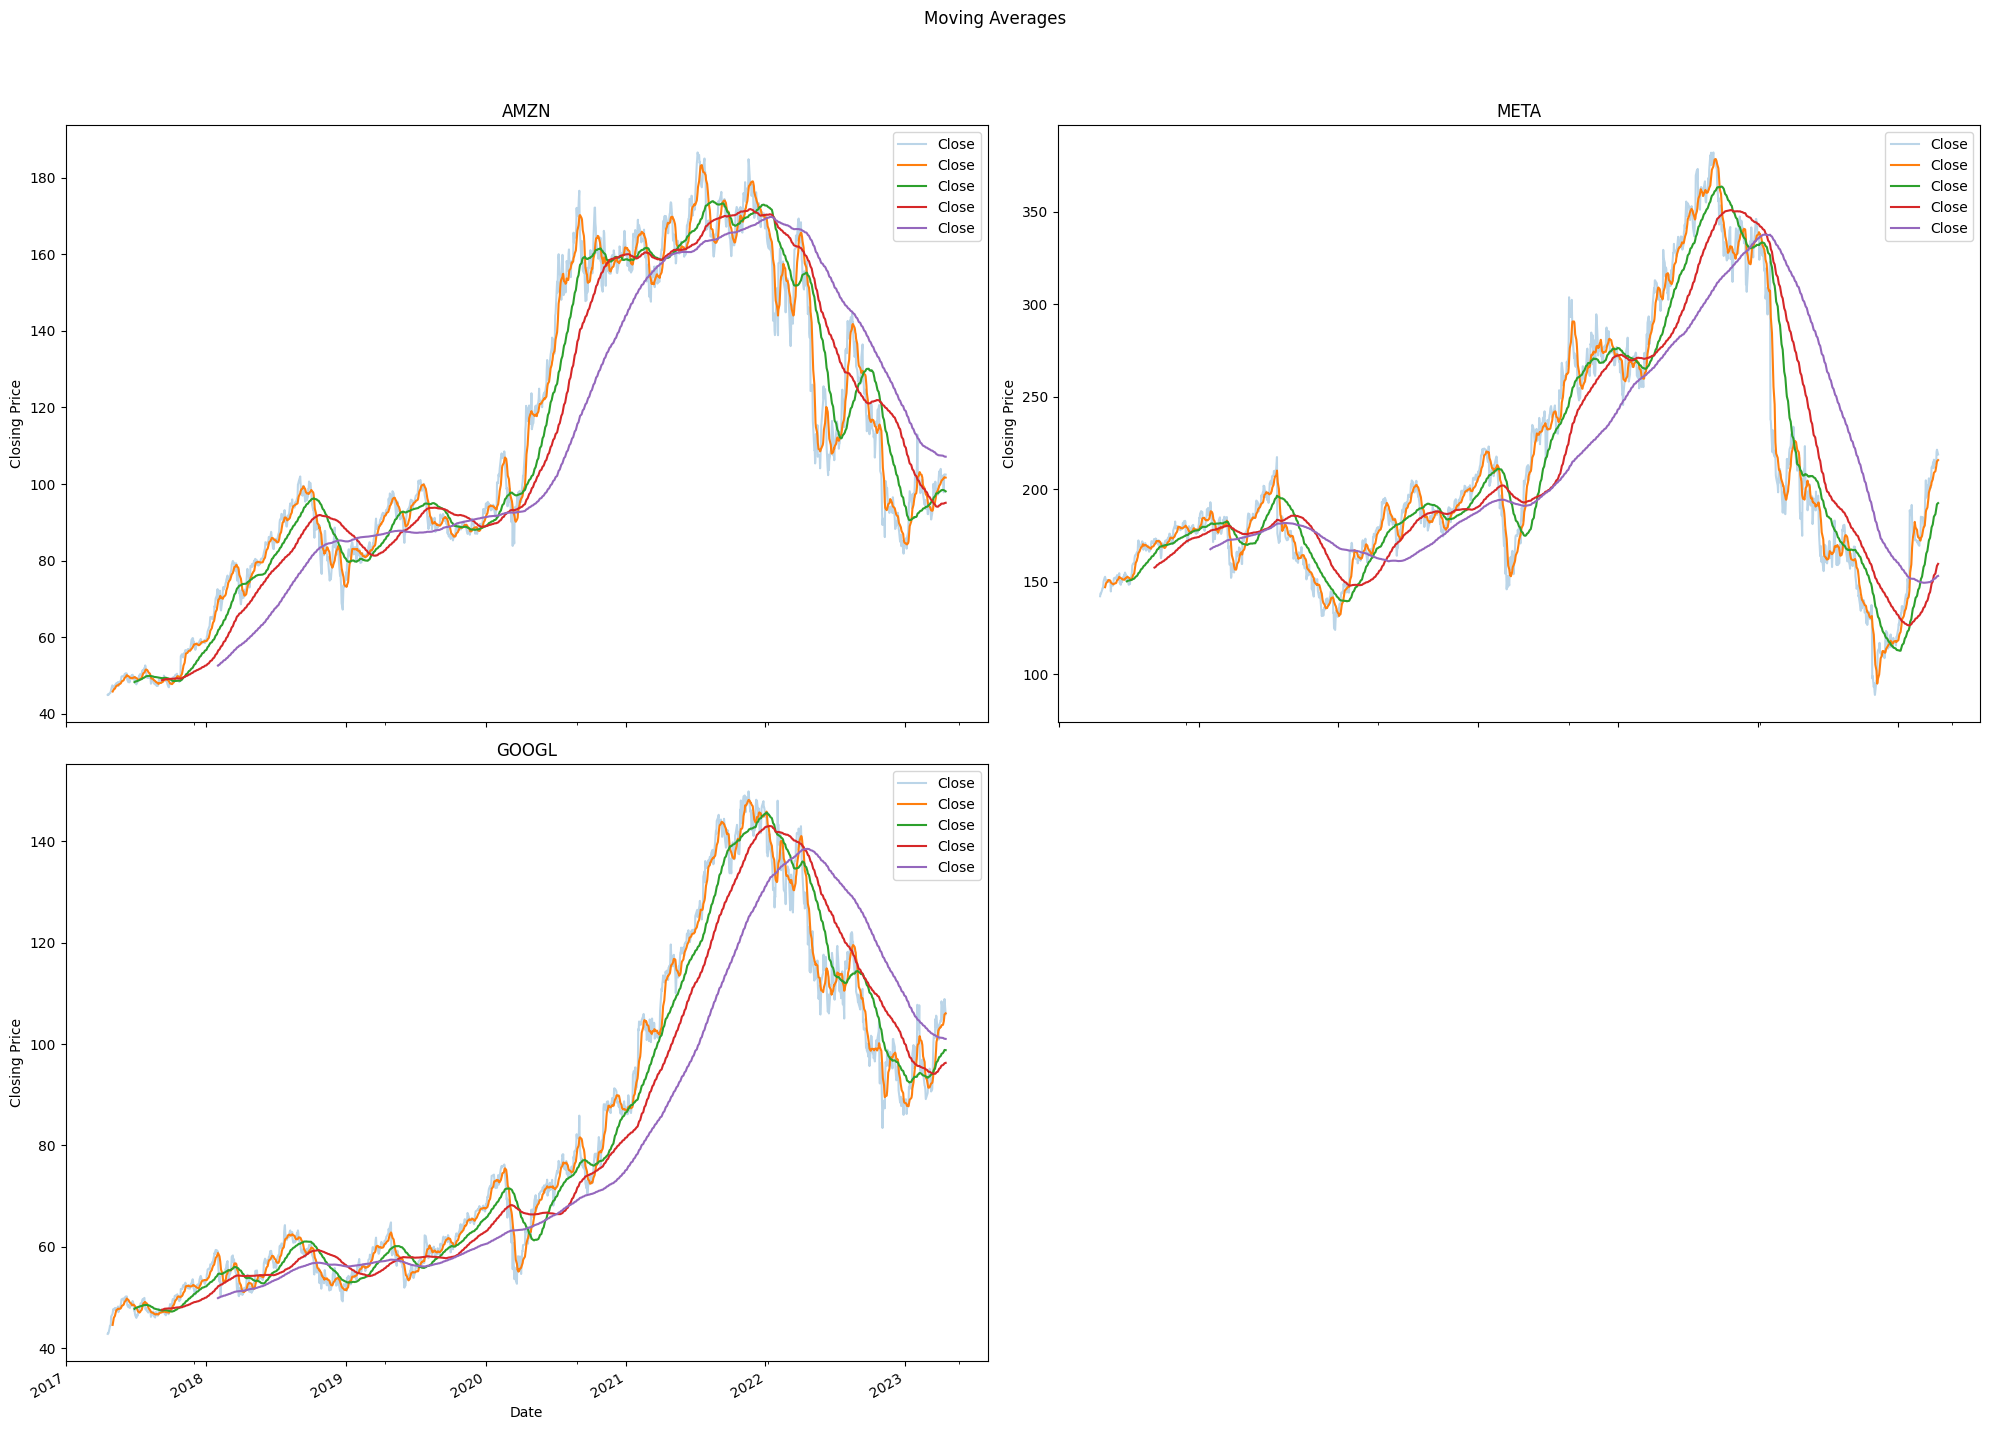

In [56]:
MA = [10, 50, 100, 200]
AdjClose = data.loc[:, (slice(None), 'Close')] 
numrows = len(tickers) // 2 + len(tickers) % 2
numcols = 2

fig, axs = plt.subplots(nrows=numrows, ncols=numcols, figsize=(20, 15), sharex=True)
fig.suptitle('Moving Averages')

for i, ticker in enumerate(tickers):
    ax = axs[i // numcols, i % numcols] 
    AdjClose[ticker].plot(ax=ax, alpha=0.3, label='Closing Price') 
    for ma in MA:
        ma_series = AdjClose[ticker].rolling(window=ma).mean()
        ma_series.plot(ax=ax, label=f'MA {ma} days')

    ax.set_title(ticker)
    ax.set_xlabel('Date')
    ax.set_ylabel('Closing Price')
    ax.legend() 

axs[-1, -1].axis('off') 

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Calculating the RSI(Relative Strength Indicator) and Moving Average Convergence Divergence (MACD)

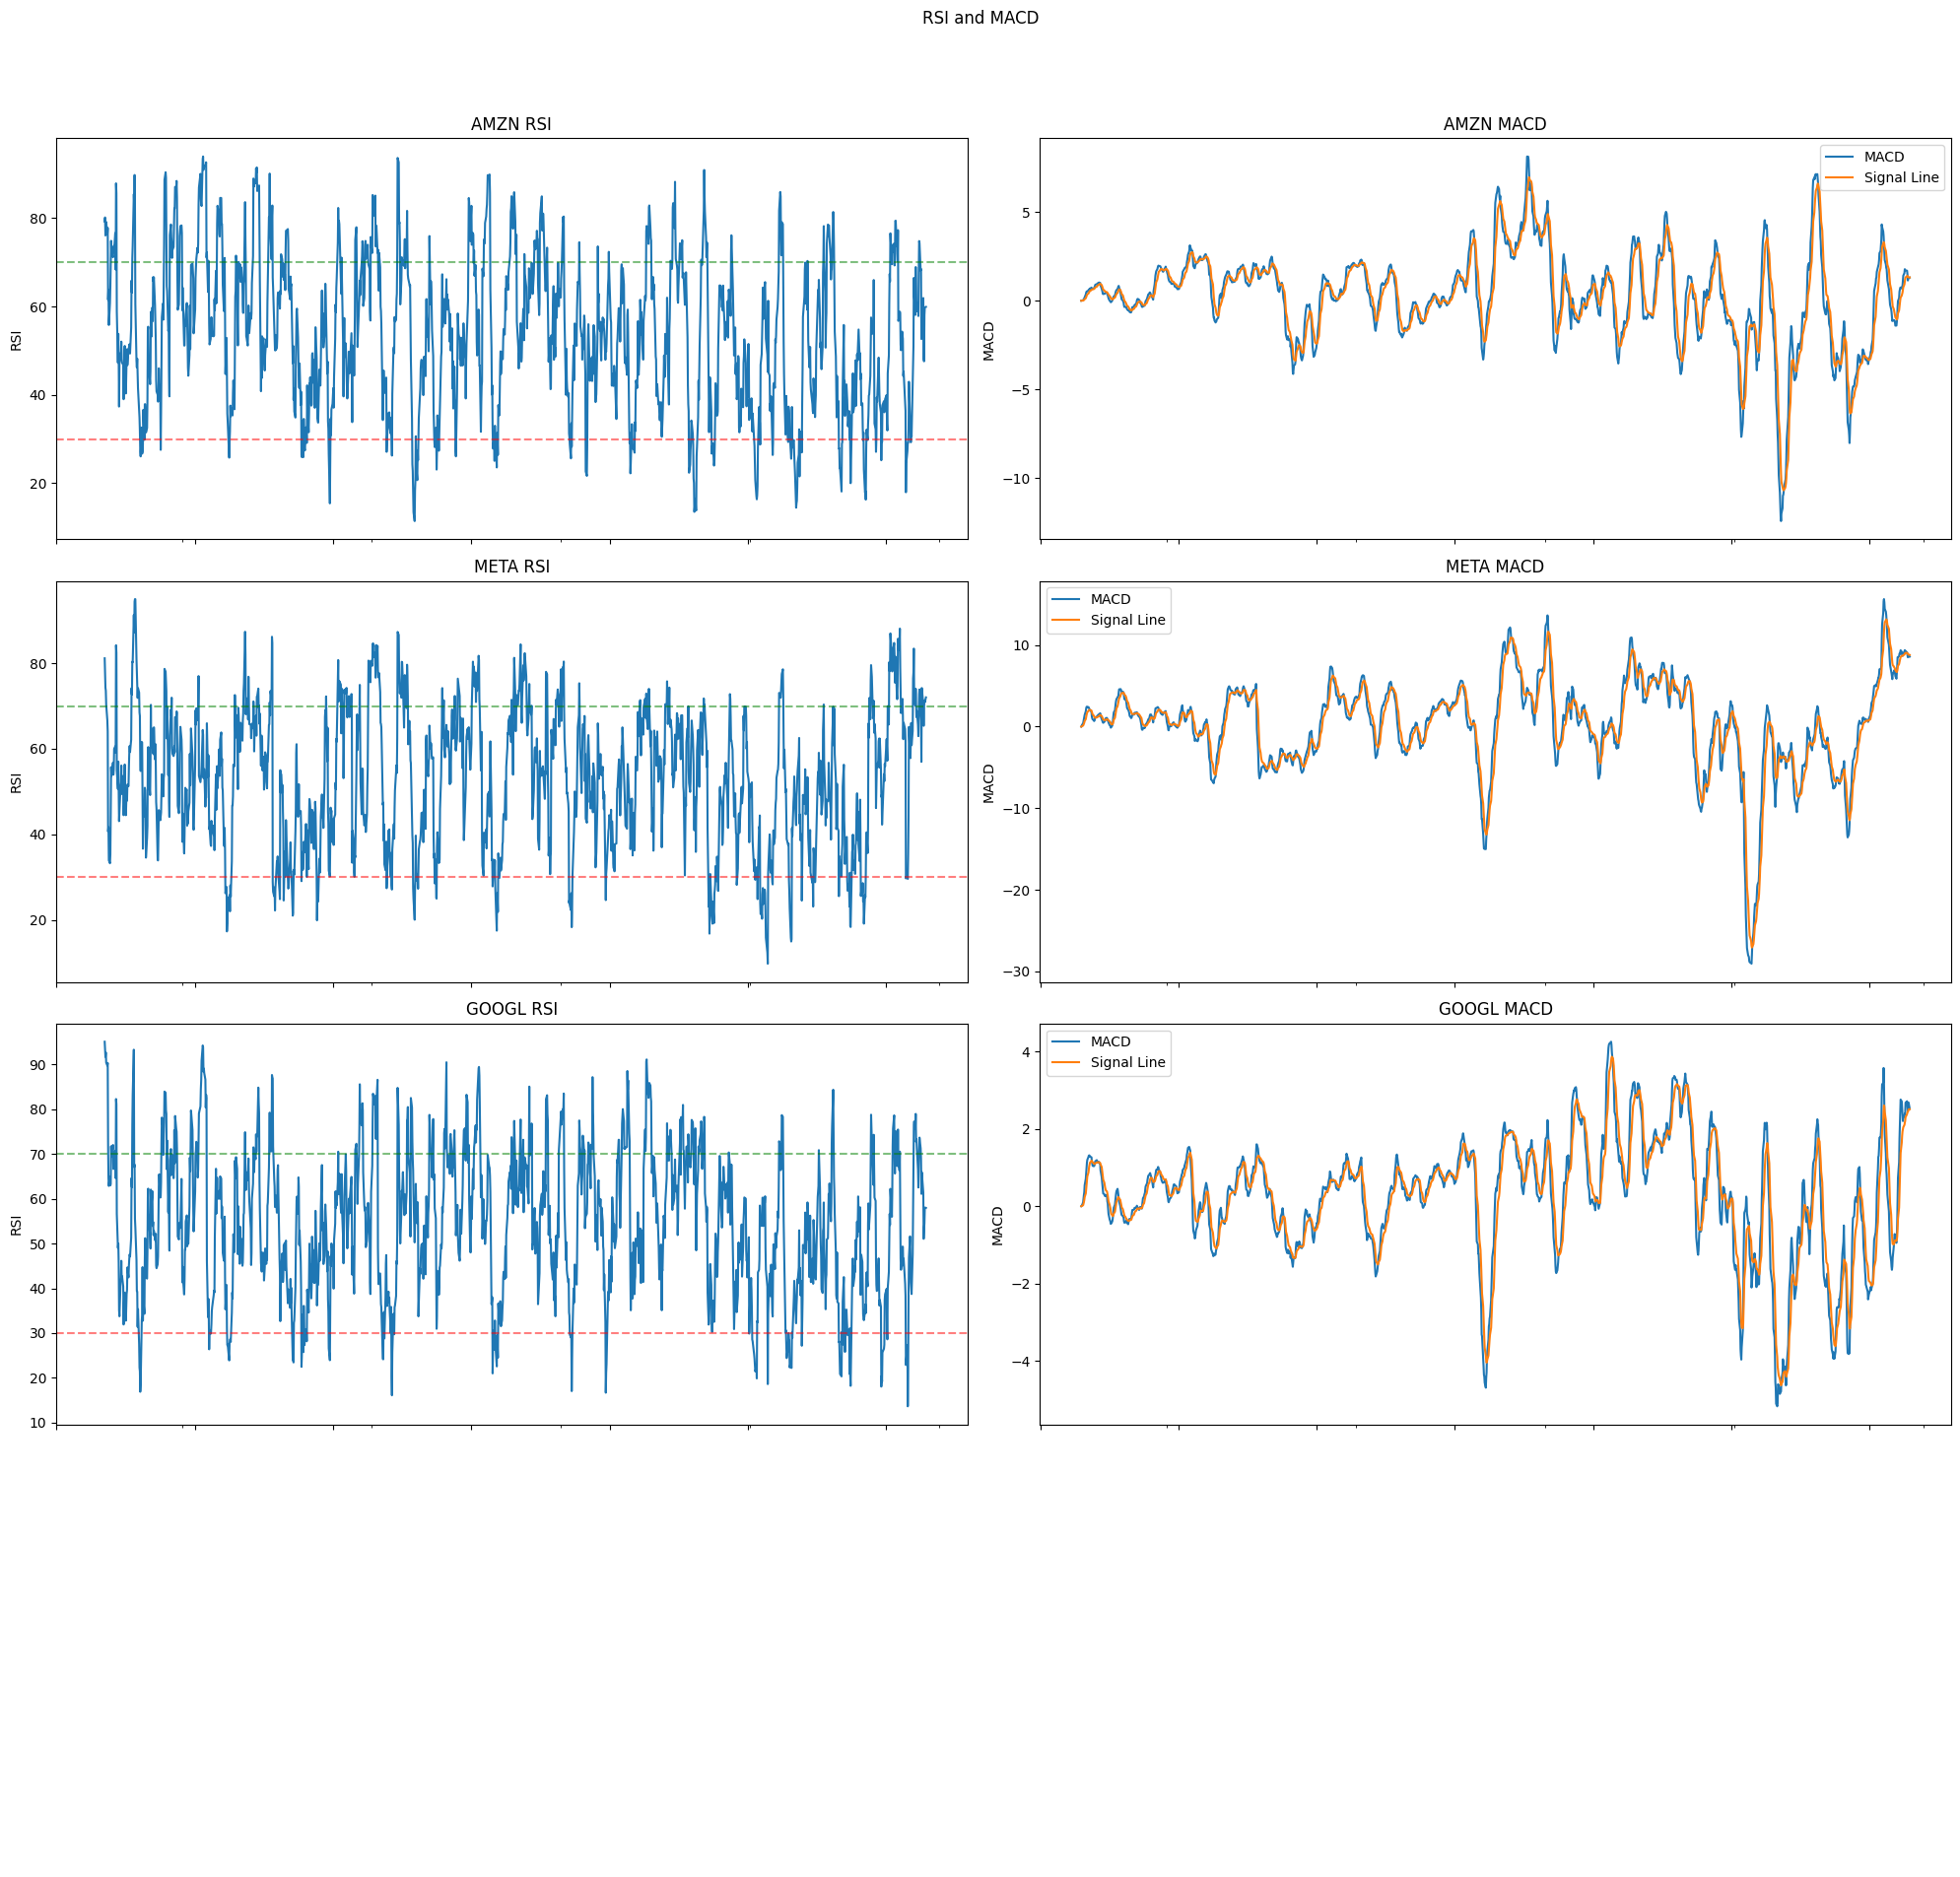

In [57]:
def macd(data, short_period=12, long_period=26, signal_period=9):
    short_ema = data['Close'].ewm(span=short_period, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_period, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    return macd_line, signal_line

def rsi(data, period=14):
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    averageGain = gain.rolling(window=period).mean()
    averageLoss = loss.rolling(window=period).mean()

    rs = averageGain / averageLoss
    rsi = 100 - (100 / (1 + rs))
    return rsi 

# Plotting the Relative Strength Index(RSI) and Moving Avergae Convergence-Divergence(MACD)
numrows = len(tickers) // 2 + len(tickers) % 2
numcols = 2

fig, axs = plt.subplots(nrows=numrows*2, ncols=numcols, figsize=(20, 20), sharex=True)
fig.suptitle('RSI and MACD')
axs_flat = axs.flatten()

for i, ticker in enumerate(tickers): 
    rsi_data = rsi(data[ticker])
    rsi_data.plot(ax=axs_flat[i*2], title=f'{ticker} RSI')
    axs_flat[i*2].axhline(30, color='red', linestyle='--', alpha=0.5)
    axs_flat[i*2].axhline(70, color='green', linestyle='--', alpha=0.5)
    axs_flat[i*2].set_xlabel('Date')
    axs_flat[i*2].set_ylabel('RSI')  

axs[-1, -2].axis('off')

for i, ticker in enumerate(tickers): 
    macd_line, signal_line = macd(data[ticker])
    macd_line.plot(ax=axs_flat[i*2+1], title=f'{ticker} MACD', label='MACD')
    signal_line.plot(ax=axs_flat[i*2+1], label='Signal Line')
    axs_flat[i*2+1].set_xlabel('Date')
    axs_flat[i*2+1].set_ylabel('MACD')
    axs_flat[i*2+1].legend()

 
axs[-1, -1].axis('off')

 
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [58]:
# Calculating the bollinger bands for each Company
def bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    ub = rolling_mean + (rolling_std * num_std)
    lb = rolling_mean - (rolling_std * num_std)
    return ub, lb


In [59]:
def plot_bollinger_bands(data, ticker, window=20, num_std=2):
    ub, lb = bollinger_bands(data, window, num_std)
    plt.figure(figsize=(15, 8))
    plt.plot(data.index, data['Close'], label=f'{ticker} Closing Prices', color='blue')
    plt.plot(data.index, ub, label='Upper-Band', color='red')
    plt.plot(data.index, lb, label='Lower-Band', color='green')
    plt.fill_between(data.index, ub, lb, color='grey', alpha=0.3)
    plt.title(f'{ticker} Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Prices')
    plt.legend()
    plt.show()

Feature Extraction

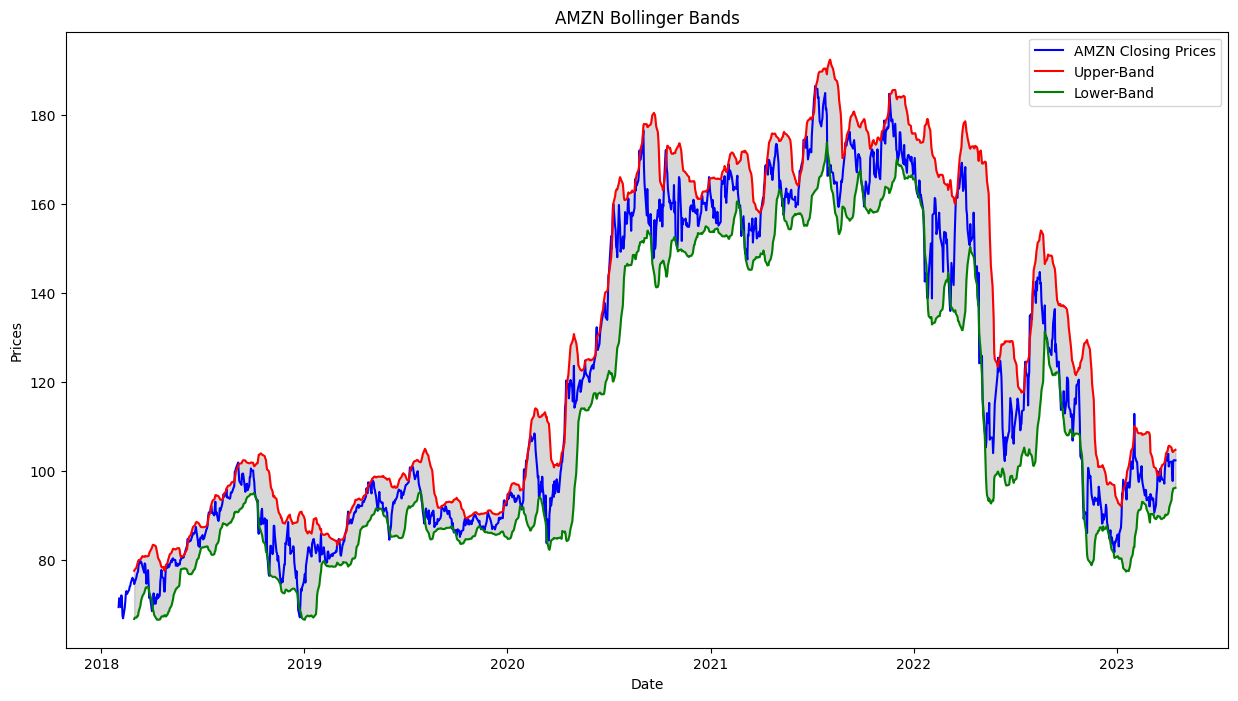

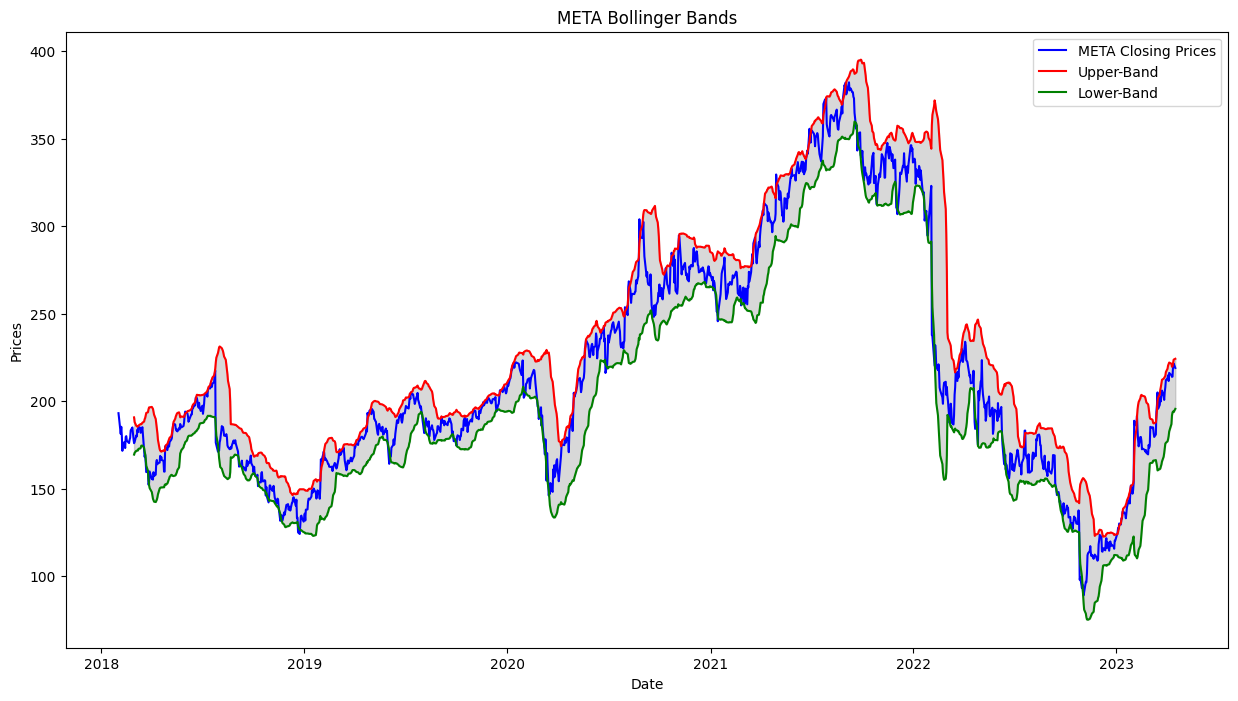

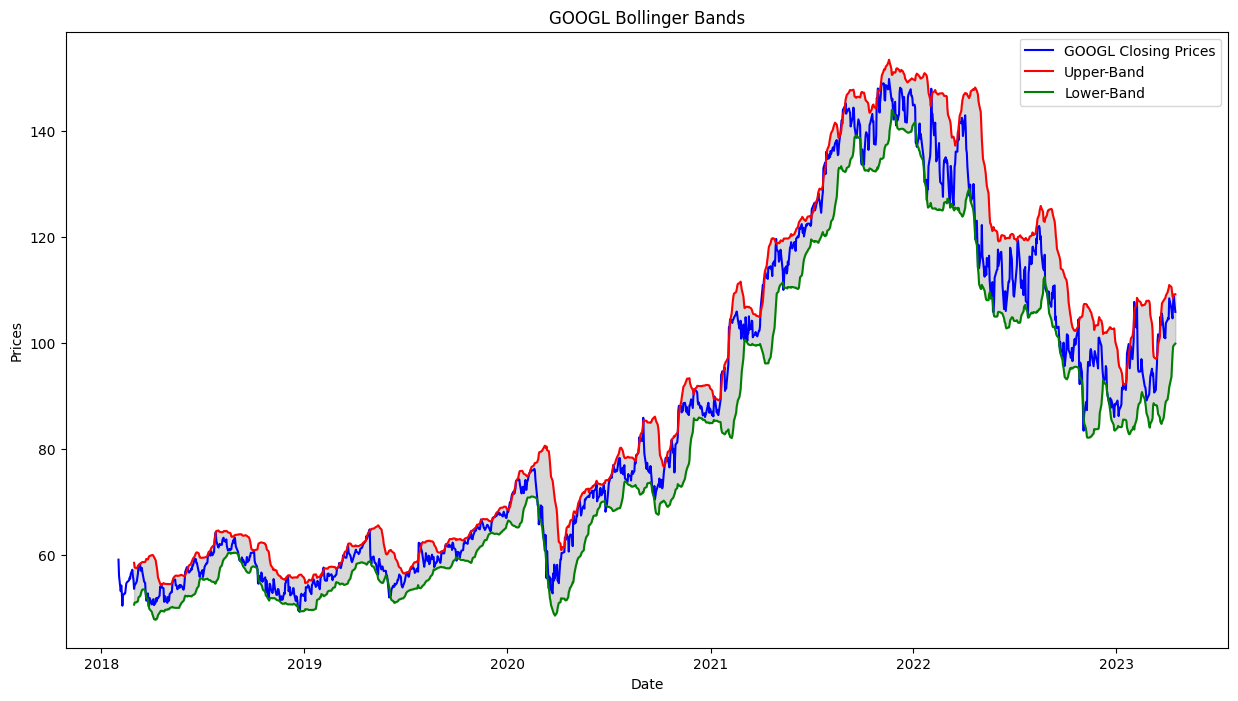

In [60]:
def addMA(data, MA):
    for ma in MA:
        data[f'MA_{ma}'] = data['Close'].rolling(window=ma).mean()
    return data
MA = [10,50,100,200] 

featureSets = {}
for ticker in tickers:
    stockFeatures = data[ticker].copy()
    stockFeatures = addMA(stockFeatures, MA)
    stockFeatures['RSI'] = rsi(stockFeatures)
    stockFeatures['MACD'], stockFeatures['Signal Line'] = macd(stockFeatures) 
    ub, lb = bollinger_bands(stockFeatures)
    stockFeatures['Upper Band'] = ub
    stockFeatures['Lower Band'] = lb
    featureSets[ticker] = stockFeatures.dropna() 

for ticker in tickers:
    stock_data = featureSets[ticker]
    plot_bollinger_bands(stock_data, ticker)

Creating Sequences of the final dataset

In [61]:
def seq(data,prev_count, targetCol ='Close'):
    X, y =[],[]
    for i in range (prev_count, len(data)):
        X.append(data.iloc[i - prev_count:i].values)
        y.append(data.iloc[i][targetCol])
    return np.array(X), np.array(y)

#below is the number of days that our model with learn from
prev_count = 60

InputOutput = {} #A dictionary declared to store the Input and Output sequence  

for ticker in tickers:
    X, y = seq(featureSets[ticker],prev_count, targetCol ='Close')
    InputOutput[ticker]= {'X': X, 'y':y}

Normalize and Scale the Data

In [62]:
ScalerFeatures = MinMaxScaler()
ScalerResponse = MinMaxScaler()
scaledIO = {}
for ticker in tickers:
    X = InputOutput[ticker]['X']
    y = InputOutput[ticker]['y']
    y = y.reshape(-1, 1) 

    #Below we scale the input variables 
    sample, timesteps, features = X.shape
    X = X.reshape(sample, -1)
    ScalerFeatures.fit(X)
    X = ScalerFeatures.transform(X)
    X = X.reshape(sample, timesteps, features)

    #Below we scale the response variable(target variable)-'Closing Price'
    ScalerResponse.fit(y)
    y = ScalerResponse.transform(y)
    scaledIO[ticker] = {'X': X, 'y': y} 


Data Splittiing

In [63]:
dataSplit = (0.5,0.25,0.25)
Split_Data = {}

for ticker in tickers:
    X = scaledIO[ticker]['X']
    y = scaledIO[ticker]['y']
    train_split = int(X.shape[0] * dataSplit[0])
    valid_split = train_split + int(X.shape[0] * dataSplit[1])
    X_train = X[:train_split]
    y_train = y[:train_split]
    X_val = X[train_split:valid_split]
    y_val = y[train_split:valid_split]
    X_test = X[valid_split:]
    y_test = y[valid_split:]

    Split_Data[ticker] = {'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val, 'X_test': X_test, 'y_test': y_test}
 

LSTM Model Development 

Processing the Stock Data for AMZN.....
Epoch 1/50
20/20 [==============================] - 14s 203ms/step - loss: 0.0304 - val_loss: 0.0197
Epoch 2/50
20/20 [==============================] - 2s 97ms/step - loss: 0.0074 - val_loss: 0.0059
Epoch 3/50
20/20 [==============================] - 2s 92ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 4/50
20/20 [==============================] - 2s 105ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 5/50
20/20 [==============================] - 2s 99ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 6/50
20/20 [==============================] - 2s 92ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 7/50
20/20 [==============================] - 2s 104ms/step - loss: 0.0035 - val_loss: 0.0074
Epoch 8/50
20/20 [==============================] - 2s 92ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 9/50
20/20 [==============================] - 2s 82ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 10/50
20/20 [==============================] - 2s 87ms/step

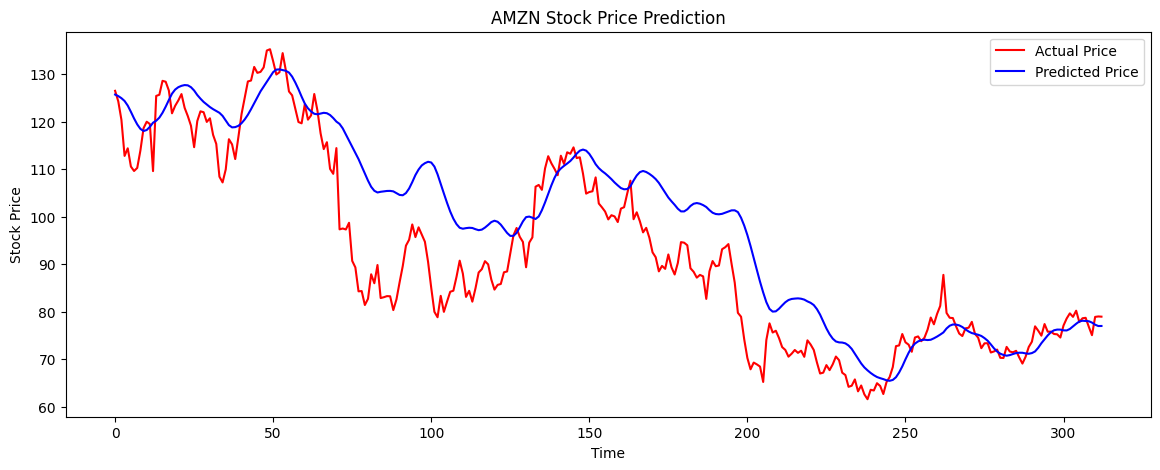

Processing the Stock Data for META.....
Epoch 1/50
20/20 [==============================] - 15s 227ms/step - loss: 0.0184 - val_loss: 0.0399
Epoch 2/50
20/20 [==============================] - 2s 101ms/step - loss: 0.0057 - val_loss: 0.0025
Epoch 3/50
20/20 [==============================] - 2s 92ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 4/50
20/20 [==============================] - 2s 97ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 5/50
20/20 [==============================] - 2s 101ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 6/50
20/20 [==============================] - 2s 94ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 7/50
20/20 [==============================] - 2s 108ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 8/50
20/20 [==============================] - 2s 107ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 9/50
20/20 [==============================] - 2s 99ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 10/50
20/20 [==============================] - 2s 98ms/st

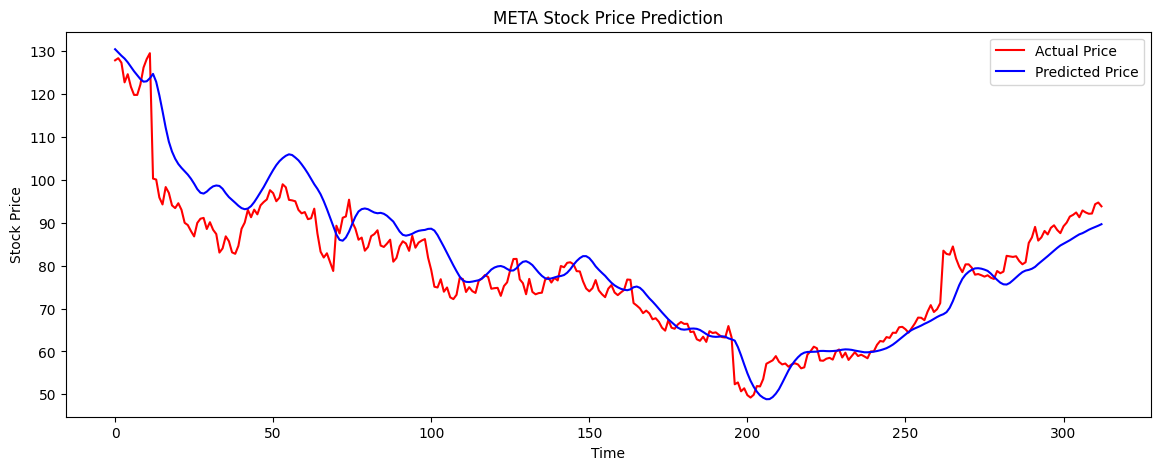

Processing the Stock Data for GOOGL.....
Epoch 1/50
20/20 [==============================] - 4s 78ms/step - loss: 0.0049 - val_loss: 0.0677
Epoch 2/50
20/20 [==============================] - 1s 41ms/step - loss: 0.0014 - val_loss: 0.0644
Epoch 3/50
20/20 [==============================] - 1s 41ms/step - loss: 0.0011 - val_loss: 0.0469
Epoch 4/50
20/20 [==============================] - 1s 40ms/step - loss: 0.0010 - val_loss: 0.0297
Epoch 5/50
20/20 [==============================] - 1s 39ms/step - loss: 9.7756e-04 - val_loss: 0.0480
Epoch 6/50
20/20 [==============================] - 1s 41ms/step - loss: 8.5341e-04 - val_loss: 0.0466
Epoch 7/50
20/20 [==============================] - 1s 41ms/step - loss: 9.2766e-04 - val_loss: 0.0228
Epoch 8/50
20/20 [==============================] - 1s 41ms/step - loss: 9.1664e-04 - val_loss: 0.0594
Epoch 9/50
20/20 [==============================] - 1s 43ms/step - loss: 8.7710e-04 - val_loss: 0.0398
Epoch 10/50
20/20 [=============================

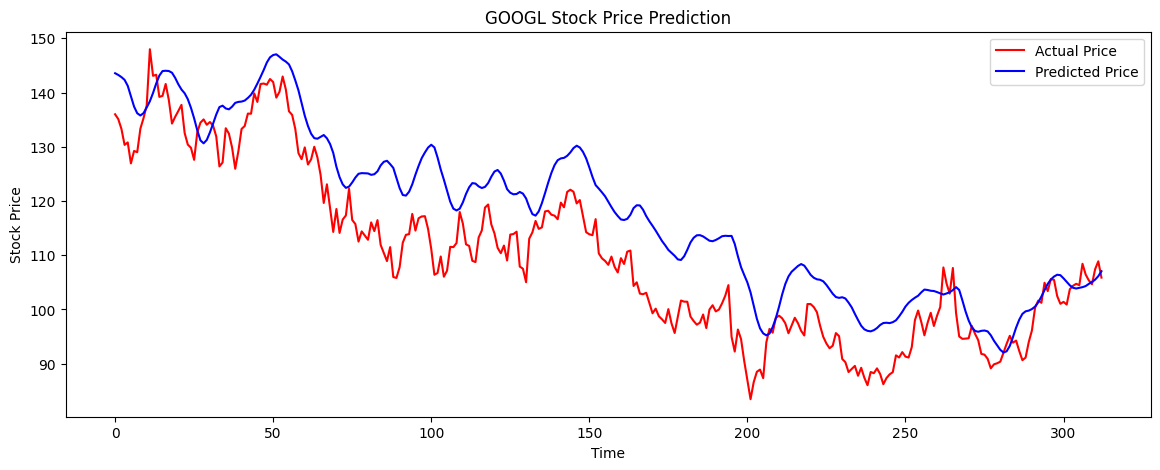

In [64]:
def lstm_model(input_shape, units, dropout_rate, layers):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape))
        elif i == layers - 1:
            model.add(LSTM(units=units))
        else:
            model.add(LSTM(units=units, return_sequences=True))
        model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    return model

# declaring the hyperparameters
layers = 3
units = 64
dropout_rate = 0.25
epochs = 50
batch_size = 32

for ticker in tickers:
    print(f'Processing the Stock Data for {ticker}')
    model = lstm_model((prev_count, Split_Data[ticker]['X_train'].shape[2]), units, dropout_rate, layers)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    history = model.fit(Split_Data[ticker]['X_train'], Split_Data[ticker]['y_train'], epochs=50, batch_size=32,
                        validation_data=(Split_Data[ticker]['X_val'], Split_Data[ticker]['y_val']))
    
    predictions = model.predict(Split_Data[ticker]['X_test'])
    predictions = ScalerResponse.inverse_transform(predictions)
     
    # Evaluation metrics 
    rmse = sqrt(mean_squared_error(Split_Data[ticker]['y_test'], predictions))
    mae = mean_absolute_error(Split_Data[ticker]['y_test'], predictions)
    print(f"{ticker} RMSE: {rmse}")
    print(f"{ticker} MAE: {mae}") 
    
    # Plotting predicted vs actual stock data
    plt.figure(figsize=(14, 5))
    plt.plot(ScalerResponse.inverse_transform(Split_Data[ticker]['y_test']), color='red', label='Actual Price')
    plt.plot(predictions, color='blue', label='Predicted Price')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()  

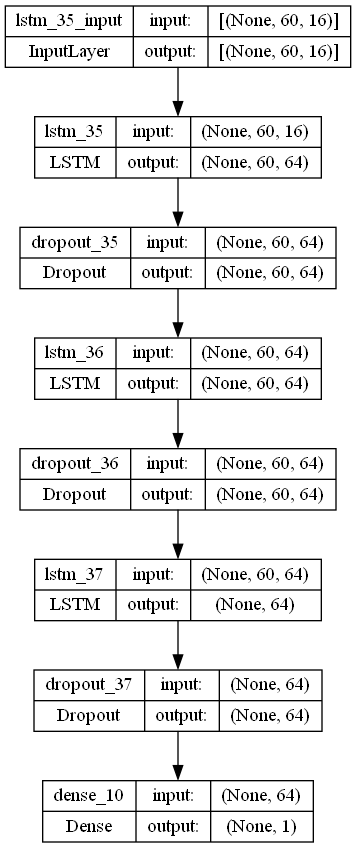

In [65]:
plot_model(model, to_file='LSTM_Model.png', show_shapes=True, show_layer_names=True)

ARIMA Model Development 

In [74]:
def fit_predict_arima(data, train_split, test_split, order):
    train_data = data[:train_split]
    test_data = data[train_split:train_split + test_split]

    model = pm.ARIMA(order=order)
    model.fit(train_data)
    forecast, confidence_interval = model.predict(n_periods=test_split, return_conf_int=True)
    return forecast, confidence_interval

#Here we will define and declare order for the ARIMA model
arima_order = (6, 1, 1)
train_split = int(len(data['AMZN']) * 0.8)
test_split = len(data['AMZN']) - train_split

for ticker in tickers:
    print(f'Processing the Stock Data for {ticker}') 
    ClosePrice = data[ticker]['Close'].values
    forecast, confidence_interval = fit_predict_arima(ClosePrice, train_split, test_split, arima_order)

    # Evaluation using metrics
    rmse = sqrt(mean_squared_error(data[ticker]['Close'].values[train_split:train_split + test_split], forecast))
    mae = mean_absolute_error(data[ticker]['Close'].values[train_split:train_split + test_split], forecast) 
    print(f"{ticker} RMSE: {rmse}")
    print(f"{ticker} MAE: {mae}")


Processing the Stock Data for AMZN
AMZN RMSE: 55.02954528373614
AMZN MAE: 47.95016468763253
Processing the Stock Data for META
META RMSE: 173.98565326601036
META MAE: 168.31265633011077
Processing the Stock Data for GOOGL
GOOGL RMSE: 44.393890207921956
GOOGL MAE: 39.35604595174964
